In [1]:
import os
import copy

import torch
import numpy as np
import pandas as pd

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

import matplotlib
import matplotlib.pyplot as plt

from src.utils import load_pickle_obj
from src.relative_embedding import DescriptorColors
from src.graph import description_graph

In [2]:
def plot_relative_embeddings(model_embeddings, 
                             target_embedding, 
                             colored_descriptions, 
                             colors,
                             dimension_reduction = 'tsne',
                             tsne_seed = 42):
    
    assert dimension_reduction in ['pca', 'tsne']
    
    colors = copy.deepcopy(colors)
    colors['black'] = (0, 0, 0)
    for color in colors:
        colors[color] =  tuple([value / 255 for value in colors[color]])
    
    
    all_descritpions = []
    for color in colored_descriptions:
        all_descritpions += colored_descriptions[color]
        
    embeddings = {}
    for des_name in all_descritpions:
        for idx in model_embeddings:
            if des_name == model_embeddings[idx]['description']:
                embeddings[des_name] = model_embeddings[idx][target_embedding]
                break
                
    assert len(embeddings) == len(all_descritpions)
    data_matrix, groups = [], []
    for des_name in embeddings:
        detect_color = 'black'
        data_matrix.append(embeddings[des_name])
        for color in colored_descriptions:
            if des_name in colored_descriptions[color]:
                detect_color = color
                break
                
        groups.append(detect_color)
        
    data_matrix = torch.stack(data_matrix).numpy()
    if dimension_reduction == 'pca':
        pca = PCA(n_components = 2)
        components = pca.fit_transform(data_matrix)
    elif dimension_reduction == 'tsne':    
        tsne = TSNE(n_components = 2, random_state = tsne_seed)
        components = tsne.fit_transform(data_matrix)
    
    df = pd.DataFrame(data = components, columns = ['Dim1', 'Dim2'])
    df['Group'] = groups
    
    plt.figure(figsize=(10, 10))
    unique_groups = df['Group'].unique()
    
    for group in unique_groups:
        indices = df['Group'] == group
        plt.scatter(df.loc[indices, 'Dim1'], 
                    df.loc[indices, 'Dim2'], 
                    c = [colors[group]], 
                    edgecolor = None, 
                    s = 100)
        
    if dimension_reduction == 'pca':
        plt.xlabel('PCA Dim 1')
        plt.ylabel('PCA Dim 2')
        plt.title('PCA of LLM embeddings')
    elif dimension_reduction == 'tsne':
        plt.xlabel('t-SNE Dim 1')
        plt.ylabel('t-SNE Dim 2')
        plt.title('t-SNE of LLM embeddings')
    
    plt.show()
    
    return None

In [3]:
graph = description_graph()
graph.help()

CoffeeDescriptionGraph(graph_name='coffee_flavor_wheel(unduplicated)', dynamic=False) of coffee_database.
Topological structure of coffee samples descriptions is stored in this object.
If want to use the API similar as CoffeeFlavorWheel, please use CoffeeDescriptionHierarchy object.

Supported methods:
CoffeeDescriptionGraph.help
CoffeeDescriptionGraph.get_connection
CoffeeDescriptionGraph.valid_construction
CoffeeDescriptionGraph.parents_of_description
CoffeeDescriptionGraph.children_of_description
CoffeeDescriptionGraph.pathways_between_descriptions
CoffeeDescriptionGraph.distance_between_descriptions
CoffeeDescriptionGraph.adjacency_matrix
CoffeeDescriptionGraph.weighted_adjacency_matrix
CoffeeDescriptionGraph.laplacian_matrix
CoffeeDescriptionGraph.weighted_laplacian_matrix
CoffeeDescriptionGraph.normalized_laplacian_matrix
CoffeeDescriptionGraph.normalized_weighted_laplacian_matrix
CoffeeDescriptionGraph.subgraph_induced_from_description
CoffeeDescriptionGraph.plot


In [4]:
def concat_folder(file_dict, folder):
    for ftype in file_dict:
        file_dict[ftype] = os.path.join(folder, file_dict[ftype])
        
    return file_dict

def load_embeddings(file_dict):
    embeddings = {}
    for embedding_type in file_dict:
        if os.path.isfile(file_dict[embedding_type]):
            embeddings[embedding_type] = load_pickle_obj(file_dict[embedding_type])
        else:
            embeddings[embedding_type] = None
            
    return embeddings

folder_name = './outputs'
albert_files = {'pretrained': 'pretrained-ALBERT_embeddings.pkl',
                'finetuned': 'finetuned-ALBERT-N5kE3_embeddings.pkl'}
bart_files = {'pretrained': 'pretrained-BART_embeddings.pkl',
              'finetuned': 'finetuned-BART-N10kE3_embeddings.pkl'}
bert_files = {'pretrained': 'pretrained-BERT_embeddings.pkl',
              'finetuned': 'finetuned-BERT-N20kE3_embeddings.pkl'}
gpt_files = {'pretrained': 'pretrained-GPT2_embeddings.pkl',
             'finetuned': 'finetuned-GPT2-N100kE8_embeddings.pkl'}
roberta_files = {'pretrained': 'pretrained-RoBERTa_embeddings.pkl',
                 'finetuned': 'finetuned-RoBERTa-N100kE1_embeddings.pkl'}
t5_files = {'pretrained': 'pretrained-T5_embeddings.pkl',
            'finetuned': 'finetuned-T5-N100kE8_embeddings.pkl'}

gemma2_files = {'pretrained': 'pretrained-Gemma2_embeddings.pkl'}
llama3_files = {'pretrained': 'pretrained-Llama3_embeddings.pkl'}
qwen2_files = {'pretrained': 'pretrained-Qwen2_embeddings.pkl'}

albert_files = concat_folder(albert_files, folder_name)
bart_files = concat_folder(bart_files, folder_name)
bert_files = concat_folder(bert_files, folder_name)
gpt_files = concat_folder(gpt_files, folder_name)
roberta_files = concat_folder(roberta_files, folder_name)
t5_files = concat_folder(t5_files, folder_name)

gemma2_files = concat_folder(gemma2_files, folder_name)
llama3_files = concat_folder(llama3_files, folder_name)
qwen2_files = concat_folder(qwen2_files, folder_name)

albert_embeddings = load_embeddings(albert_files)
bart_embeddings = load_embeddings(bart_files)
bert_embeddings = load_embeddings(bert_files)
gpt_embeddings = load_embeddings(gpt_files)
roberta_embeddings = load_embeddings(roberta_files)
t5_embeddings = load_embeddings(t5_files)

gemma2_embeddings = load_embeddings(gemma2_files)
llama3_embeddings = load_embeddings(llama3_files)
qwen2_embeddings = load_embeddings(qwen2_files)

In [5]:
colored_descriptions = {}

for descritpion in graph.descriptions:
    for color in DescriptorColors:
        if graph.distance_between_descriptions(descritpion, color) < 10.:
            if color not in colored_descriptions.keys():
                colored_descriptions[color] = [descritpion]
            else:
                colored_descriptions[color].append(descritpion)  
                
for color in colored_descriptions:
    colored_descriptions[color] = list(set(colored_descriptions[color]))

/Users/zhangyutang/.pyenv/versions/3.8.10/lib/python3.8/site-packages/threadpoolctl.py:1214: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


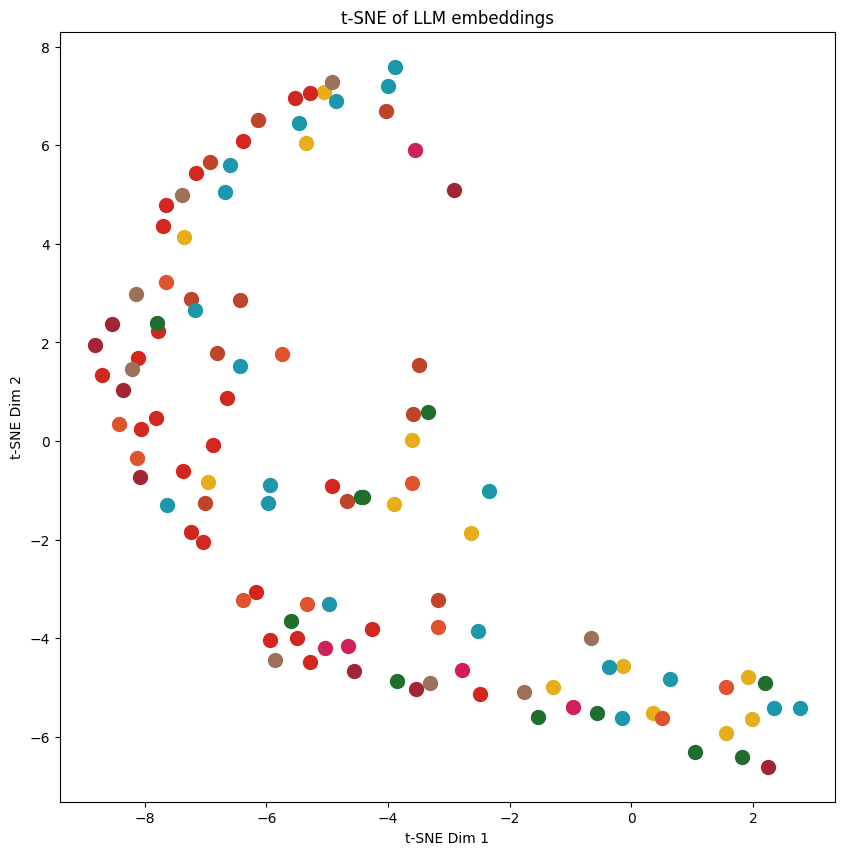

In [6]:
# pretained ALBERT
if albert_embeddings['pretrained'] is not None:
    plot_relative_embeddings(albert_embeddings['pretrained'],
                             'relative_encoder_embedding',
                             colored_descriptions,
                             DescriptorColors)

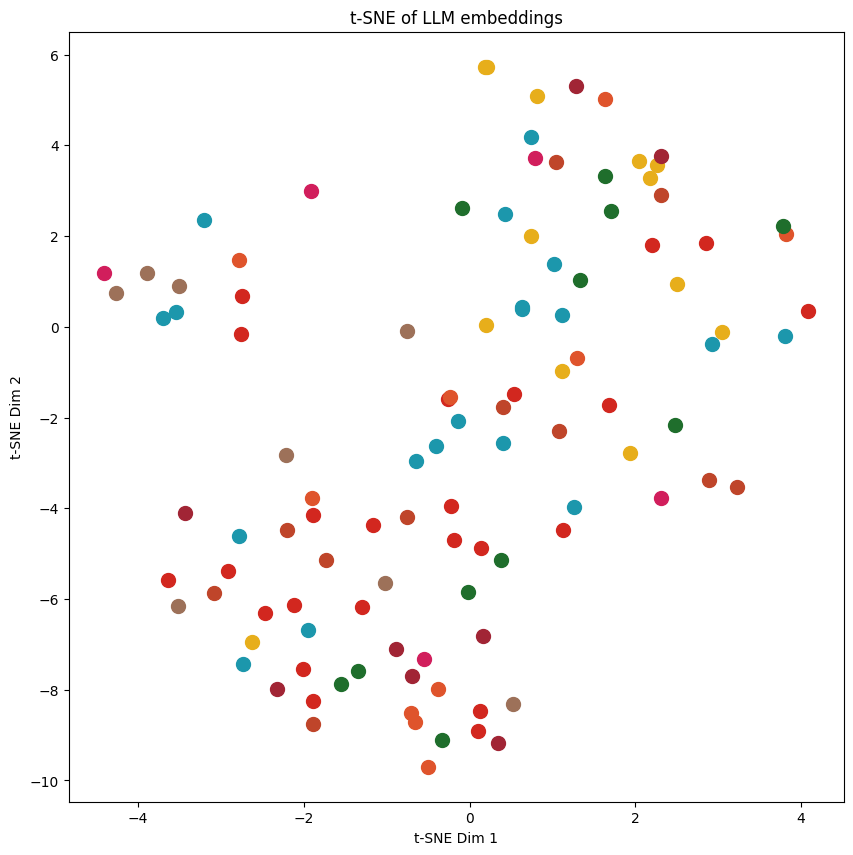

In [7]:
# finetuned ALBERT
if albert_embeddings['finetuned'] is not None:
    plot_relative_embeddings(albert_embeddings['finetuned'],
                             'relative_encoder_embedding',
                             colored_descriptions,
                             DescriptorColors)

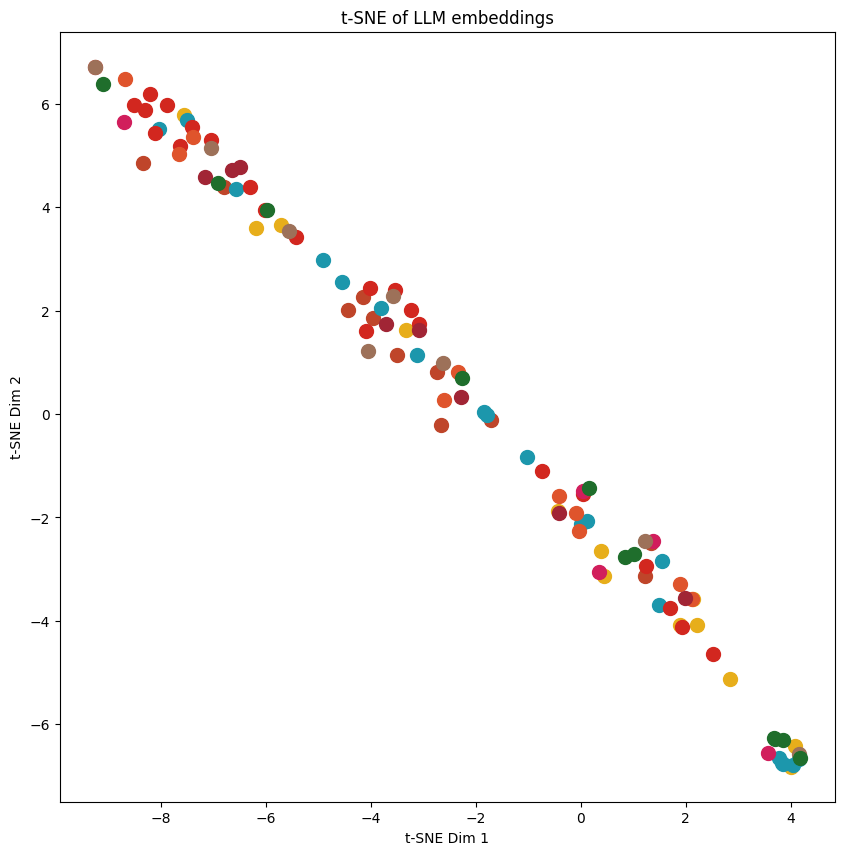

In [8]:
# pretained BART encoder
if bart_embeddings['pretrained'] is not None:
    plot_relative_embeddings(bart_embeddings['pretrained'],
                             'relative_encoder_embedding',
                             colored_descriptions,
                             DescriptorColors)

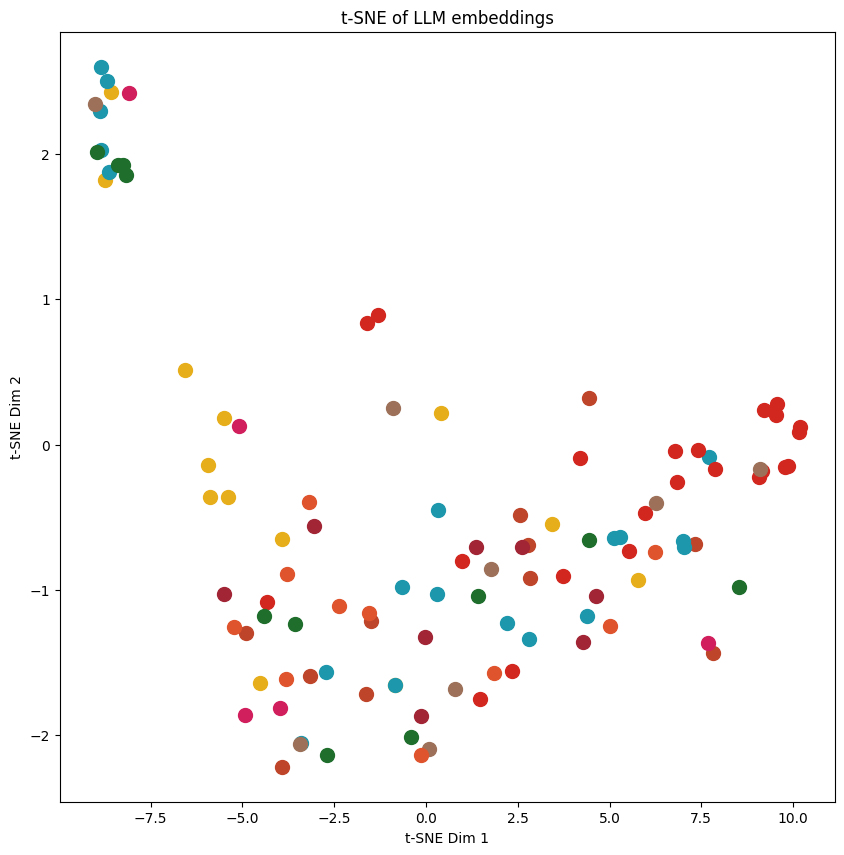

In [9]:
# finetuned BART encoder
if bart_embeddings['finetuned'] is not None:
    plot_relative_embeddings(bart_embeddings['finetuned'],
                             'relative_encoder_embedding',
                             colored_descriptions,
                             DescriptorColors)

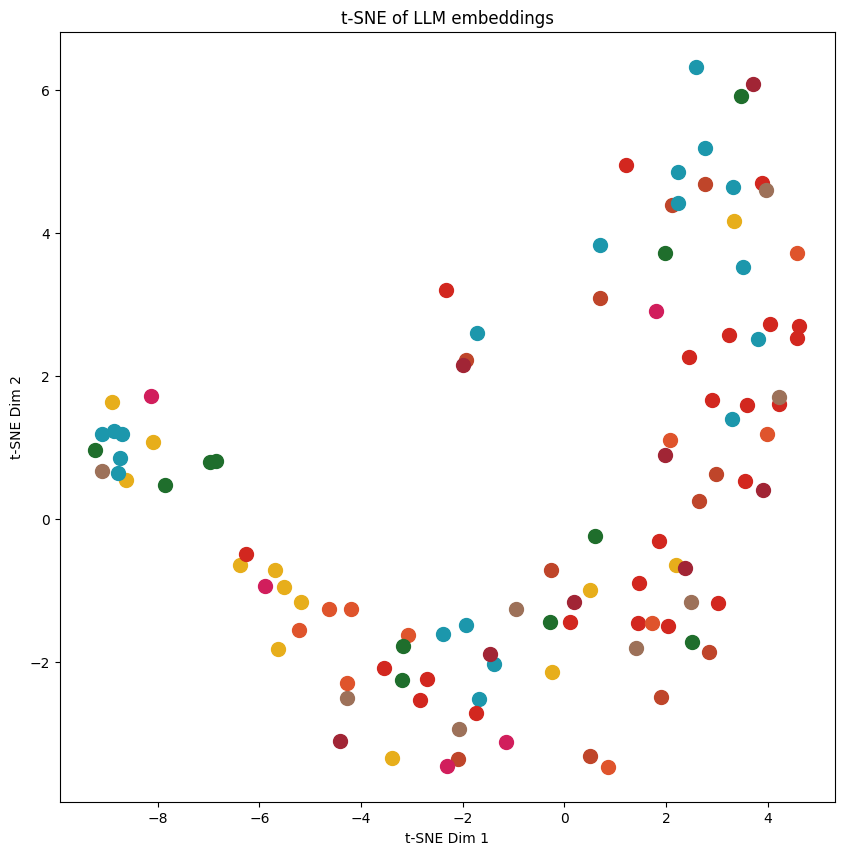

In [10]:
# pretained BART decoder
if bart_embeddings['pretrained'] is not None:
    plot_relative_embeddings(bart_embeddings['pretrained'],
                             'relative_decoder_embedding',
                             colored_descriptions,
                             DescriptorColors)

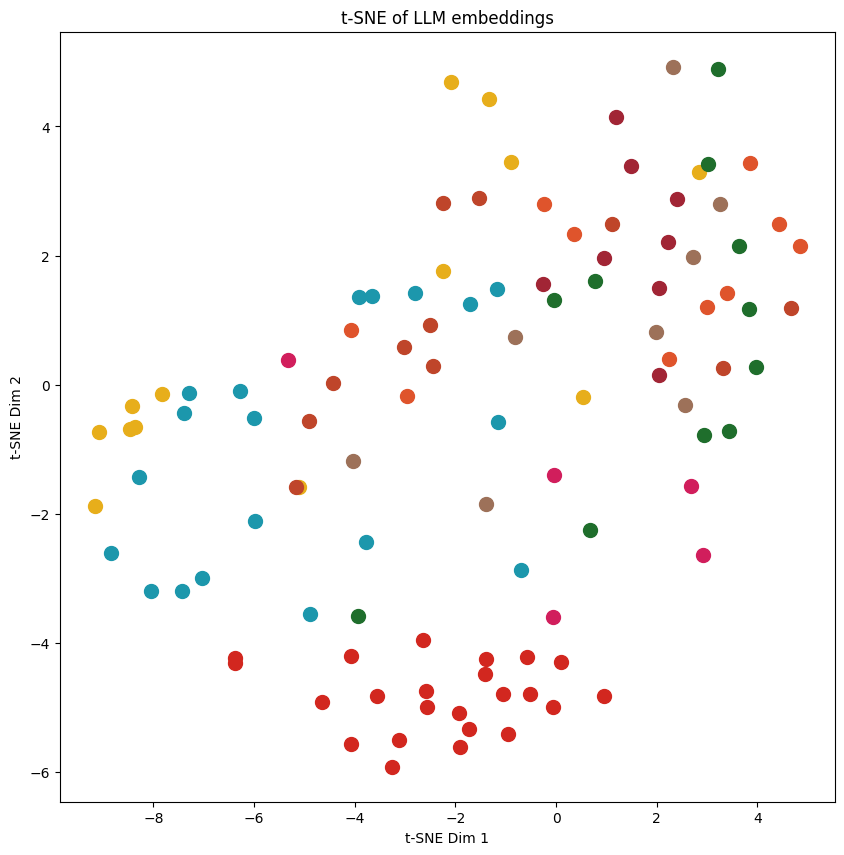

In [11]:
# finetuned BART decoder
if bart_embeddings['finetuned'] is not None:
    plot_relative_embeddings(bart_embeddings['finetuned'],
                             'relative_decoder_embedding',
                             colored_descriptions,
                             DescriptorColors)

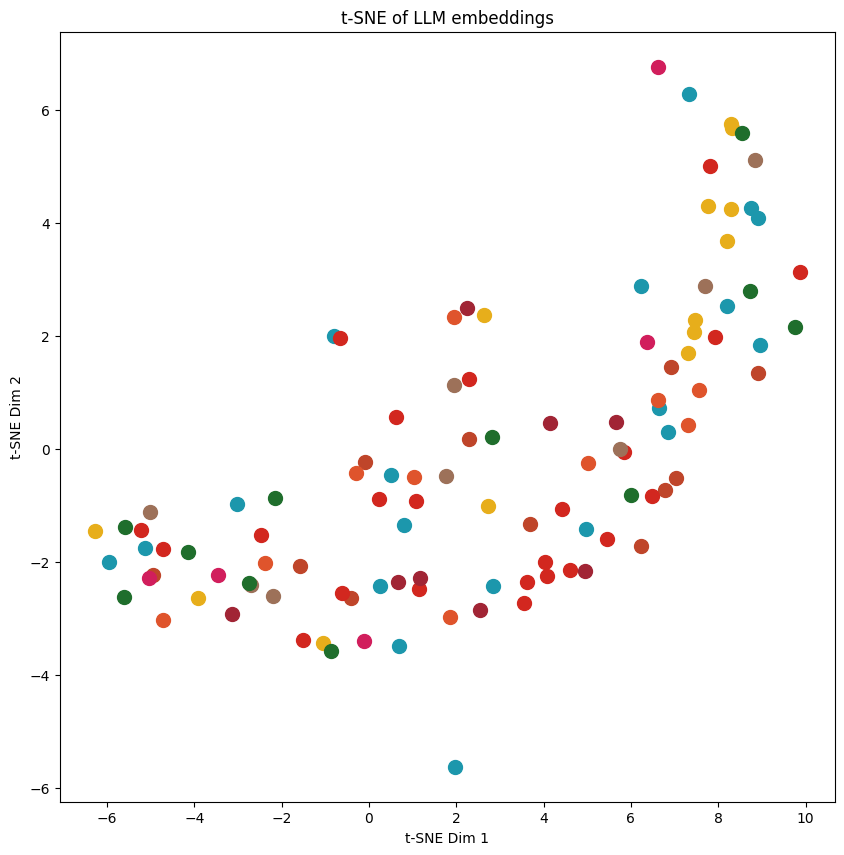

In [12]:
# pretained BERT
if bert_embeddings['pretrained'] is not None:
    plot_relative_embeddings(bert_embeddings['pretrained'],
                             'relative_encoder_embedding',
                             colored_descriptions,
                             DescriptorColors)

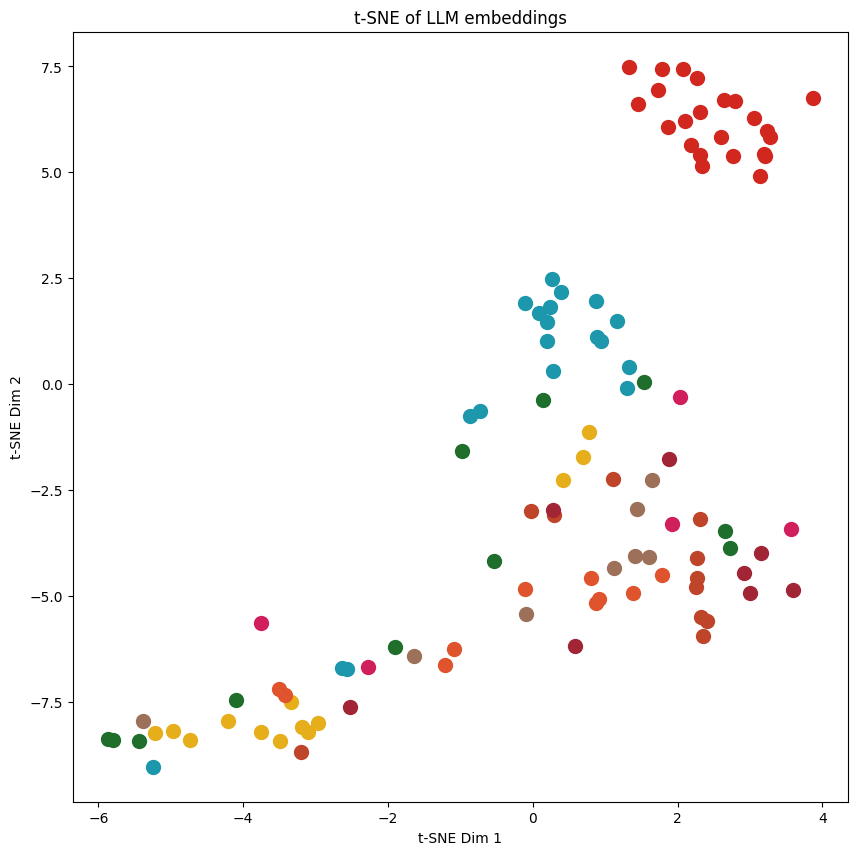

In [13]:
# finetuned BERT
if bert_embeddings['finetuned'] is not None:
    plot_relative_embeddings(bert_embeddings['finetuned'],
                             'relative_encoder_embedding',
                             colored_descriptions,
                             DescriptorColors)

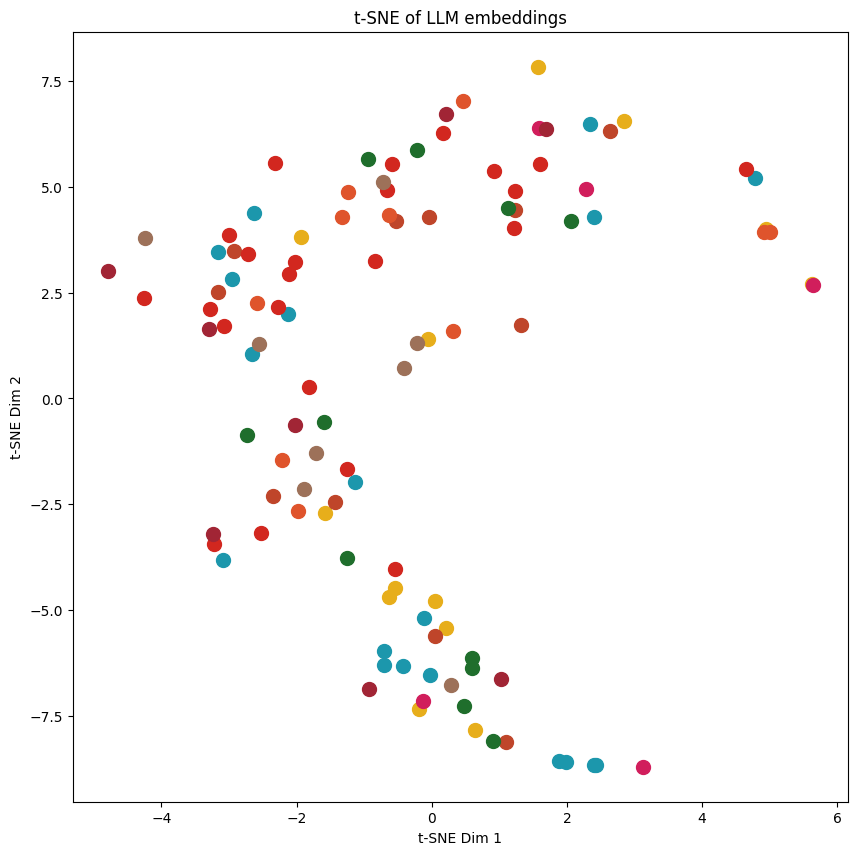

In [14]:
# pretained GPT
if gpt_embeddings['pretrained'] is not None:
    plot_relative_embeddings(gpt_embeddings['pretrained'],
                             'relative_decoder_embedding',
                             colored_descriptions,
                             DescriptorColors)

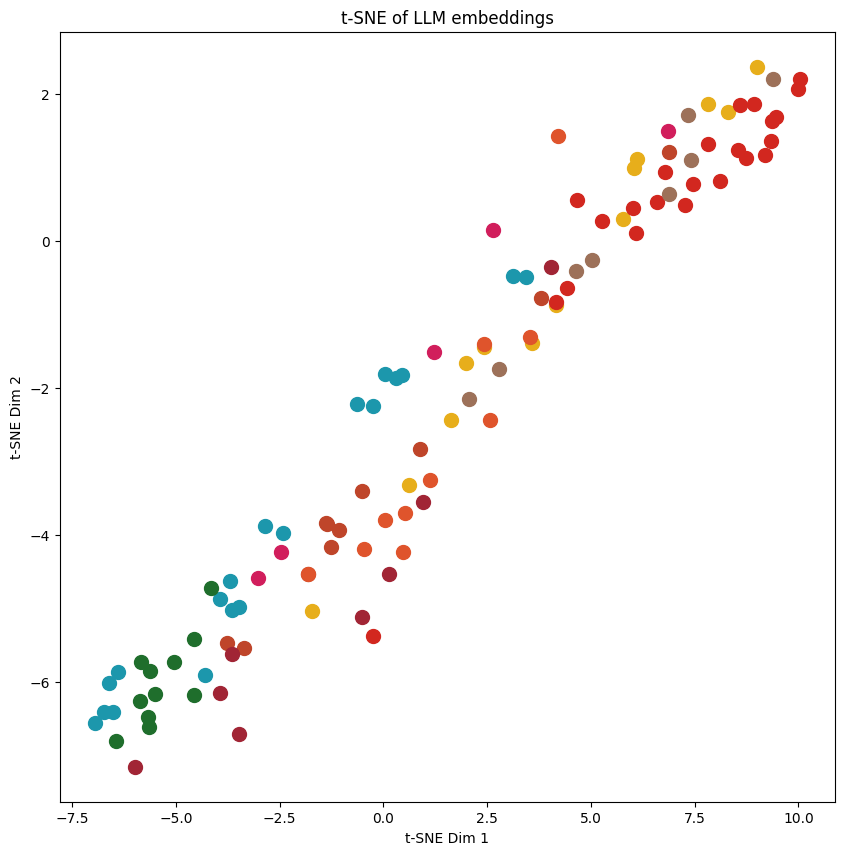

In [15]:
# pretained GPT
if gpt_embeddings['finetuned'] is not None:
    plot_relative_embeddings(gpt_embeddings['finetuned'],
                             'relative_decoder_embedding',
                             colored_descriptions,
                             DescriptorColors)

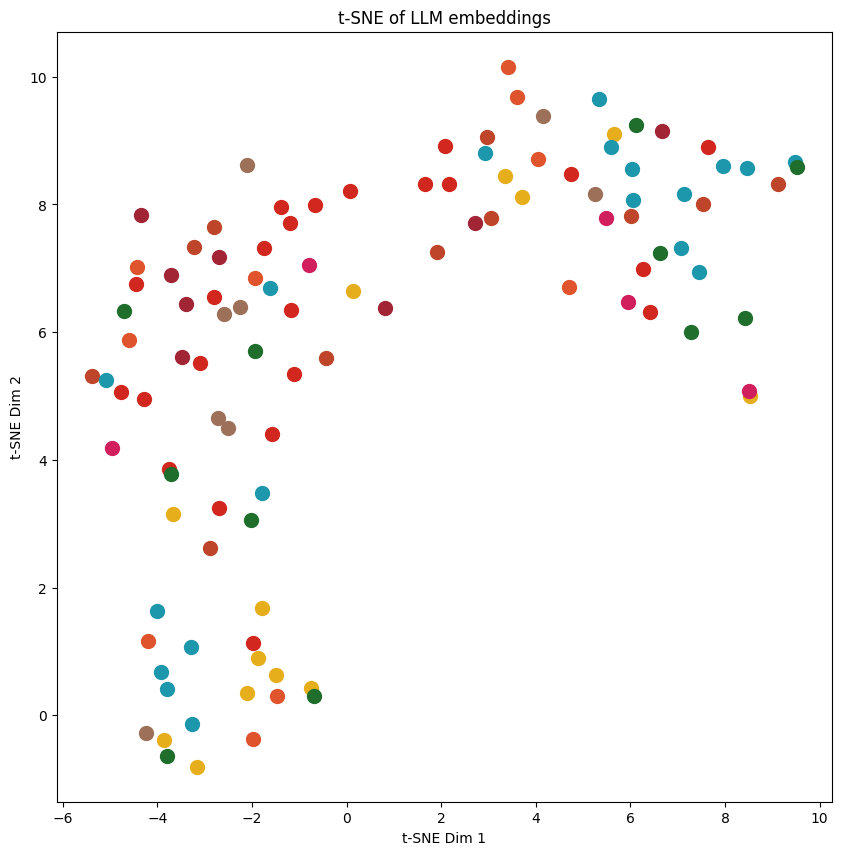

In [16]:
# pretained RoBERTa
if roberta_embeddings['pretrained'] is not None:
    plot_relative_embeddings(roberta_embeddings['pretrained'],
                             'relative_encoder_embedding',
                             colored_descriptions,
                             DescriptorColors)

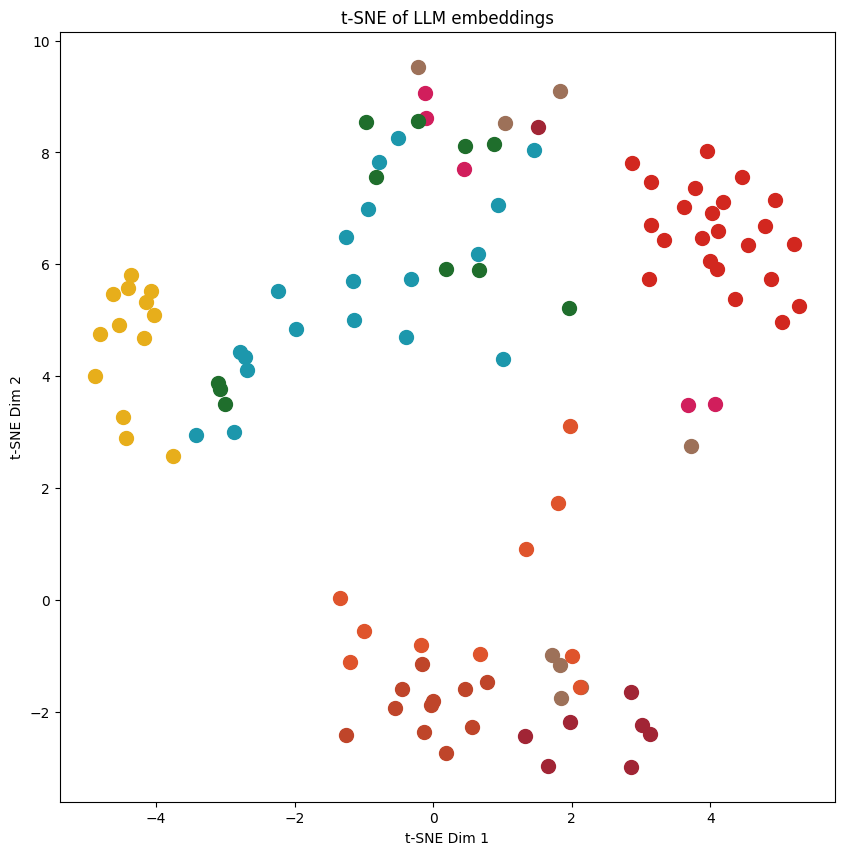

In [17]:
# finetuned RoBERTa
if roberta_embeddings['finetuned'] is not None:
    plot_relative_embeddings(roberta_embeddings['finetuned'],
                             'relative_encoder_embedding',
                             colored_descriptions,
                             DescriptorColors)

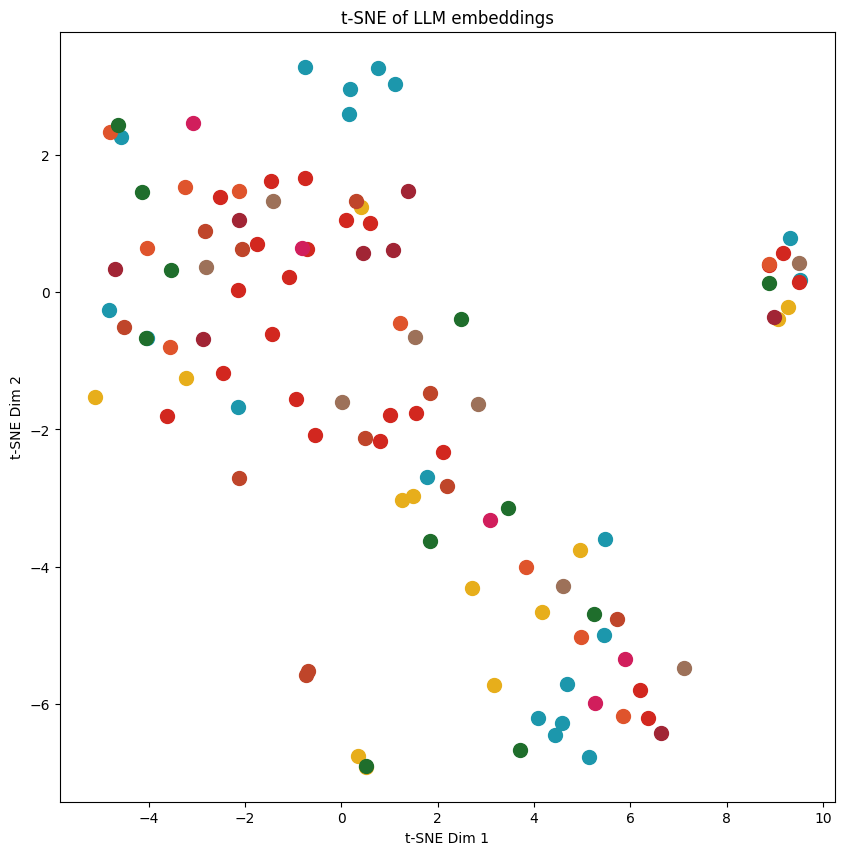

In [18]:
# pretained T5 encoder
if t5_embeddings['pretrained'] is not None:
    plot_relative_embeddings(t5_embeddings['pretrained'],
                             'relative_encoder_embedding',
                             colored_descriptions,
                             DescriptorColors)

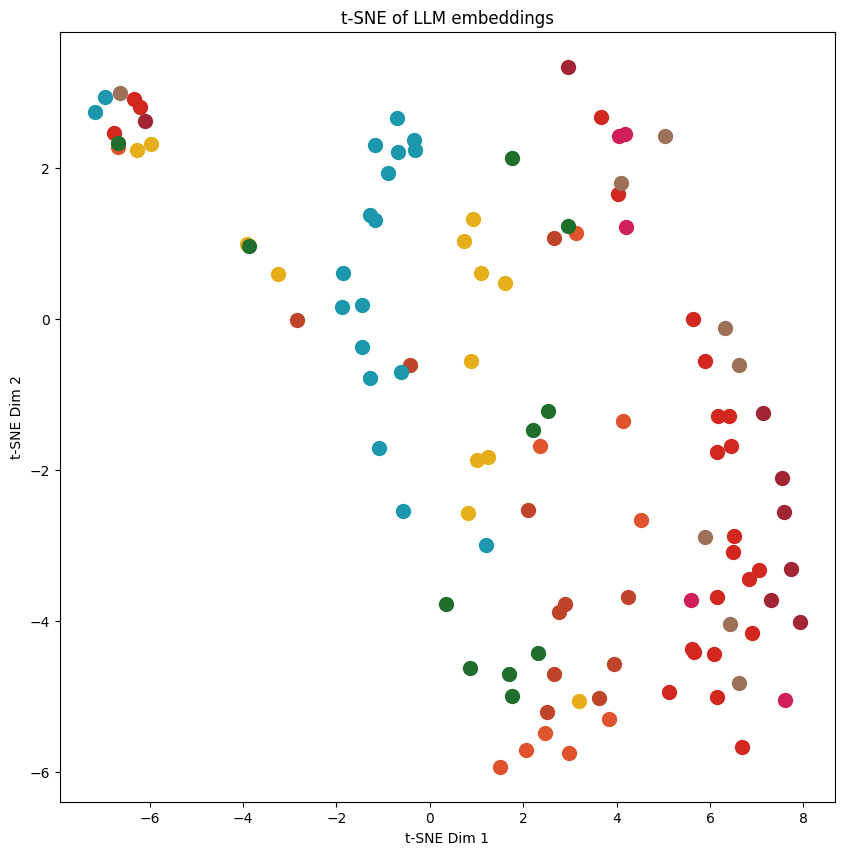

In [19]:
# finetuned T5 encoder
if t5_embeddings['finetuned'] is not None:
    plot_relative_embeddings(t5_embeddings['finetuned'],
                             'relative_encoder_embedding',
                             colored_descriptions,
                             DescriptorColors)

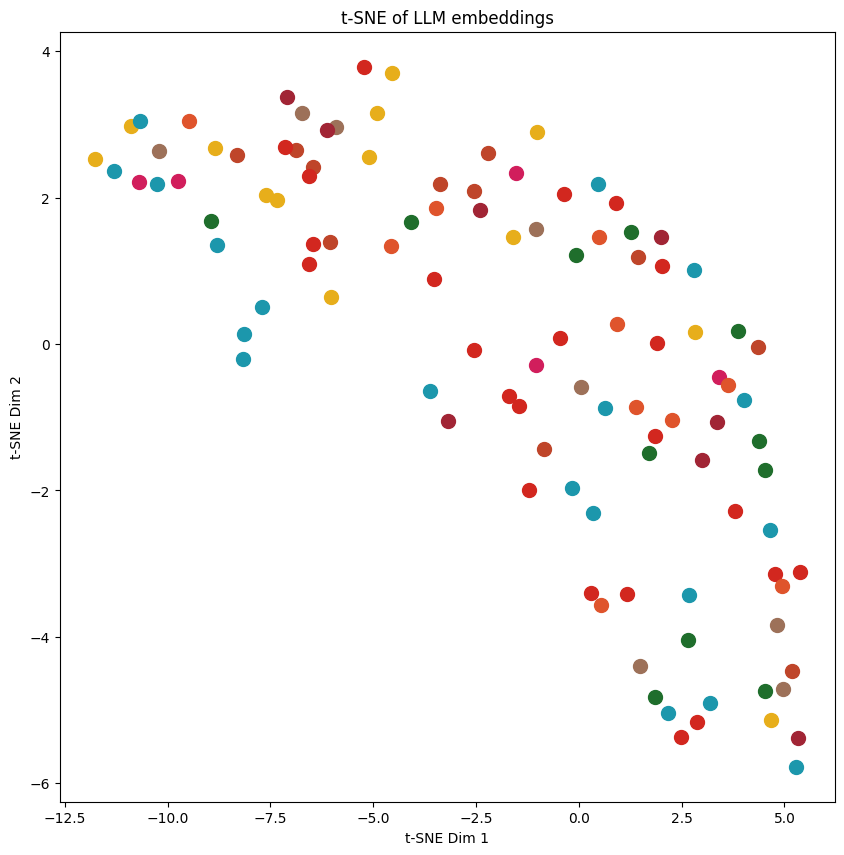

In [20]:
# pretained T5 decoder
if t5_embeddings['pretrained'] is not None:
    plot_relative_embeddings(t5_embeddings['pretrained'],
                             'relative_decoder_embedding',
                             colored_descriptions,
                             DescriptorColors)

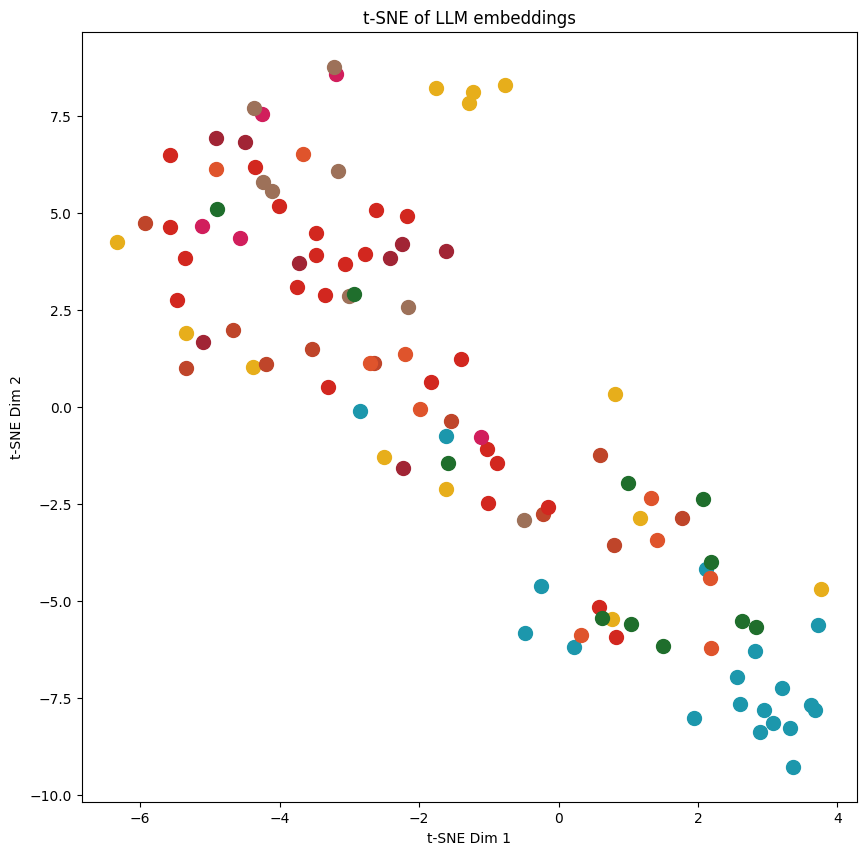

In [21]:
# finetuned T5 decoder
if t5_embeddings['finetuned'] is not None:
    plot_relative_embeddings(t5_embeddings['finetuned'],
                             'relative_decoder_embedding',
                             colored_descriptions,
                             DescriptorColors)

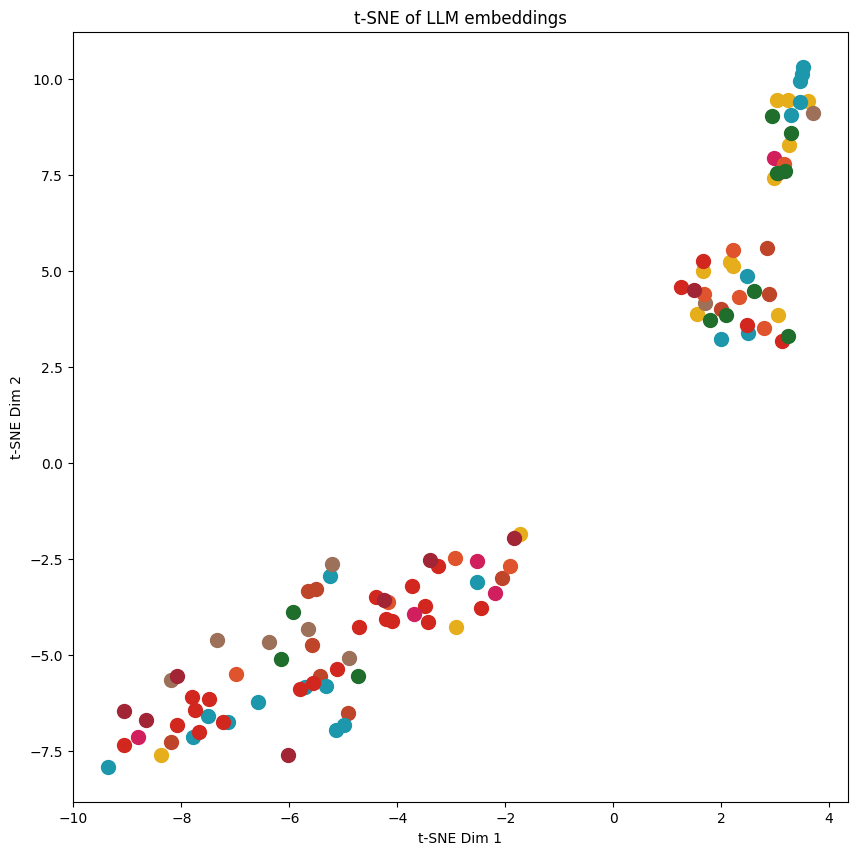

In [22]:
# pretained Gemma2
if gemma2_embeddings['pretrained'] is not None:
    plot_relative_embeddings(gemma2_embeddings['pretrained'],
                             'relative_decoder_embedding',
                             colored_descriptions,
                             DescriptorColors)

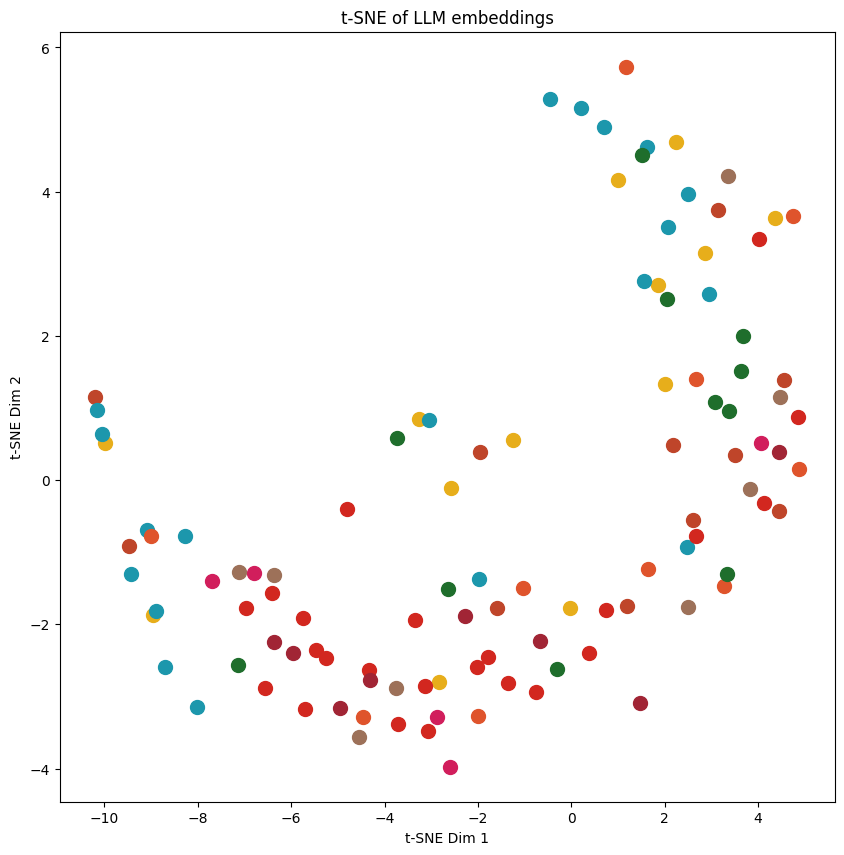

In [23]:
# pretained Llama3
if llama3_embeddings['pretrained'] is not None:
    plot_relative_embeddings(llama3_embeddings['pretrained'],
                             'relative_decoder_embedding',
                             colored_descriptions,
                             DescriptorColors)

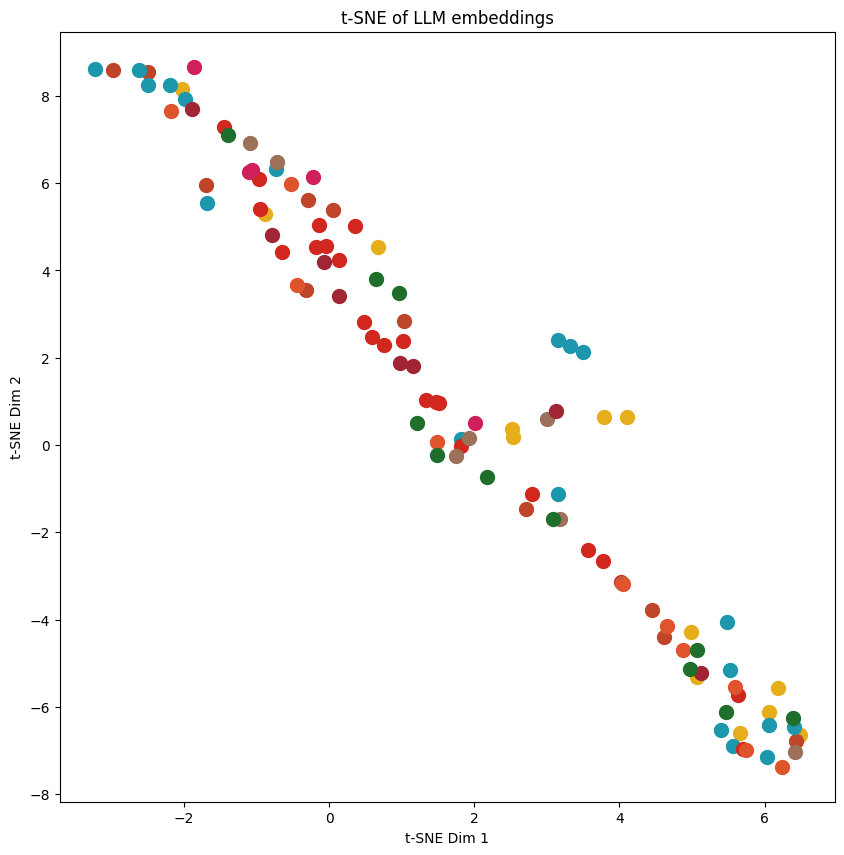

In [24]:
# pretained Qwen2
if qwen2_embeddings['pretrained'] is not None:
    plot_relative_embeddings(qwen2_embeddings['pretrained'],
                             'relative_decoder_embedding',
                             colored_descriptions,
                             DescriptorColors)